In [25]:
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(org.Hs.eg.db)
library(annotate)
library(stringr)
library(XML)
library(qqman)
library(rtracklayer)

In [26]:
data <- read.csv(file='../data/vst_results.csv')
data$chr <- sub("^", "chr", data$chr)

data$X <- NULL
data

chr,start,end,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,SouthAsia.Africa,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,228416,267160,0.00888,0.01589,0.03326,0.04202,0.01588,0.00841,0.01985,⋯,0.02353,0.09138,0.01521,0.02111,0.13688,0.02606,0.04539,0.08230,0.04721,0.02251
chr1,471226,471326,0.01656,0.08613,0.01001,0.01862,0.04420,0.00859,0.12591,⋯,0.05997,0.17269,0.04347,0.08381,0.02733,0.04270,0.01370,0.11817,0.02574,0.04746
chr1,712534,763301,0.01447,0.05338,0.02077,0.02643,0.04762,0.01282,0.09619,⋯,0.03036,0.01701,0.01521,0.06423,0.02219,0.04843,0.03433,0.02487,0.03913,0.05833
chr1,763301,763482,0.01353,0.01351,0.03442,0.01351,0.01351,0.02386,0.03401,⋯,0.06028,NA,NA,0.04361,0.05488,0.05409,0.01549,NA,0.03723,0.03637
chr1,769541,787076,0.01029,0.00848,0.01327,0.01619,0.03137,0.01214,0.01325,⋯,0.01718,0.02273,0.03380,0.01429,0.03704,0.03011,0.01370,0.04545,0.02941,0.02619
chr1,787076,787479,0.03454,NA,0.03704,NA,NA,0.03537,0.03288,⋯,0.03704,NA,NA,0.03261,0.03704,0.03704,0.01370,NA,0.02941,0.02899
chr1,795270,797682,0.01763,0.01351,0.02829,0.03180,0.03533,0.04097,0.02542,⋯,0.03704,0.04167,0.04545,0.04300,0.01967,0.02079,0.01648,0.02188,0.01632,0.01583
chr1,810543,811145,0.01434,0.01899,0.02366,0.02234,0.01351,0.02288,0.01575,⋯,0.01510,0.01638,0.02273,0.01247,0.01995,0.03704,0.01370,0.04167,0.01457,0.02898
chr1,811145,812525,0.01448,0.01899,0.02366,0.01351,0.02832,0.01438,0.01571,⋯,0.01510,0.02273,0.01572,0.01389,0.03704,0.02054,0.01441,0.04545,0.02174,0.01608


In [27]:
coordinates <- data[, c(1,2,3)]
names(coordinates) <- c("Chromosome", "Start", "End")

In [28]:
intervals = GenomicRanges::makeGRangesFromDataFrame(coordinates)
txdb = TxDb.Hsapiens.UCSC.hg19.knownGene

In [29]:
intervals

GRanges object with 8650 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1       228416-267160      *
     [2]     chr1       471226-471326      *
     [3]     chr1       712534-763301      *
     [4]     chr1       763301-763482      *
     [5]     chr1       769541-787076      *
     ...      ...                 ...    ...
  [8646]     chrX 154776475-154788811      *
  [8647]     chrX 154788811-154840186      *
  [8648]     chrX 154789310-154826421      *
  [8649]     chrX 154892549-154908191      *
  [8650]     chrX 154908191-154948137      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [30]:
#Gene ids 
genes = genes(txdb)

  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [31]:
# Annotating function
annotateIntervals <-
    function(intervals, txdb)
{
    stopifnot(is(intervals, "GRanges"), is(txdb, "TxDb"))
    anno = genes(txdb)
    olaps = findOverlaps(intervals, anno)
    mcols(olaps)$gene_id = genes$gene_id[subjectHits(olaps)]
    intervals_factor = factor(queryHits(olaps), levels=seq_len(queryLength(olaps)))
    intervals$gene_id = splitAsList(mcols(olaps)$gene_id, intervals_factor)
    intervals
}     

In [32]:
myAnnotation <- as.data.frame(annotateIntervals(intervals, txdb))
myDf_master <- data.frame()


  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



In [33]:
for (i in 1:length(myAnnotation$gene_id)) {
  if(length(c(na.omit(myAnnotation$gene_id[i])[[1]])) != 0) {
  myDf <- data.frame(myAnnotation$seqnames[i], myAnnotation$start[i], 
    myAnnotation$end[i], toString(unname(getSYMBOL(c(na.omit(myAnnotation$gene_id[i])[[1]]), data='org.Hs.eg'))))
  myDf_master <- rbind(myDf_master, myDf)
 }
}


In [34]:
myDf_header <- c("chr", "start", "end", "genes")
names(myDf_master) <- myDf_header


In [35]:
df_merge <- merge(myDf_master,data,by=c("chr", "start","end"))


In [39]:
df_merge$chr <- gsub("chr","",as.character(df_merge$chr))

write.csv(df_merge,"vst_gene_anotation.csv", row.names = FALSE)


### Changing X chromosome to 23 for manhattan plot 
df_merge$chr <- as.integer(df_merge$chr)
df_merge$chr[is.na(df_merge$chr)] <- 23
df_merge

chr,start,end,genes,WestEurasia.SouthAsia,WestEurasia.Africa,WestEurasia.CentralAsiaSiberia,WestEurasia.Oceania,WestEurasia.America,WestEurasia.EastAsia,⋯,Africa.CentralAsiaSiberia,Africa.Oceania,Africa.America,Africa.EastAsia,CentralAsiaSiberia.Oceania,CentralAsiaSiberia.America,CentralAsiaSiberia.EastAsia,Oceania.America,Oceania.EastAsia,America.EastAsia
<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,100517299,100523294,MFSD14A,0.02564,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,10067509,10076124,RBP7,NA,0.05392,NA,NA,NA,NA,⋯,0.04199,0.04064,0.03967,0.04837,NA,NA,NA,NA,NA,NA
1,1009660,1015541,RNF223,0.00887,0.01756,0.03523,0.01265,0.05813,0.00853,⋯,0.02193,0.01637,0.04604,0.01794,0.03761,0.03089,0.03854,0.07820,0.01585,0.06727
1,102395735,102403958,OLFM3,0.01826,0.00856,0.01720,0.01689,0.01667,0.01878,⋯,0.02273,0.02273,0.02273,0.02273,NA,NA,NA,NA,NA,NA
1,10272327,10278119,KIF1B,NA,0.02273,NA,0.04167,NA,NA,⋯,0.02273,0.02773,0.02273,0.02273,0.04167,NA,NA,0.04167,0.04167,NA
1,10282248,10326922,KIF1B,NA,0.02273,NA,NA,NA,NA,⋯,0.02273,0.02273,0.02273,0.02273,NA,NA,NA,NA,NA,NA
1,1051484,1053875,C1orf159,0.01914,0.01685,0.01532,0.01823,0.01195,0.00852,⋯,0.04243,0.01478,0.01700,0.01776,0.05387,0.03921,0.02405,0.02446,0.02169,0.01570
1,10630864,10650632,PEX14,0.01707,0.01351,0.01351,0.01351,0.01351,0.14320,⋯,NA,NA,NA,0.12932,NA,NA,0.10556,NA,0.09998,0.09593
1,107891259,107899854,NTNG1,0.01729,0.01759,0.02796,0.01620,0.01603,0.00837,⋯,0.06064,NA,NA,0.02174,0.05517,0.05436,0.02950,NA,0.02174,0.02174


In [37]:
#Input for Manhattan plot
SNP <- df_merge$genes
CHR <- df_merge$chr
BP <- df_merge$start
P <- df_merge$Africa.America
df <- data.frame(SNP,CHR,BP,P)
df$P[is.na(df$P)] <- 0

df

SNP,CHR,BP,P
<chr>,<dbl>,<int>,<dbl>
MFSD14A,1,100517299,0.00000
RBP7,1,10067509,0.03967
RNF223,1,1009660,0.04604
OLFM3,1,102395735,0.02273
KIF1B,1,10272327,0.02273
KIF1B,1,10282248,0.02273
C1orf159,1,1051484,0.01700
PEX14,1,10630864,0.00000
NTNG1,1,107891259,0.00000


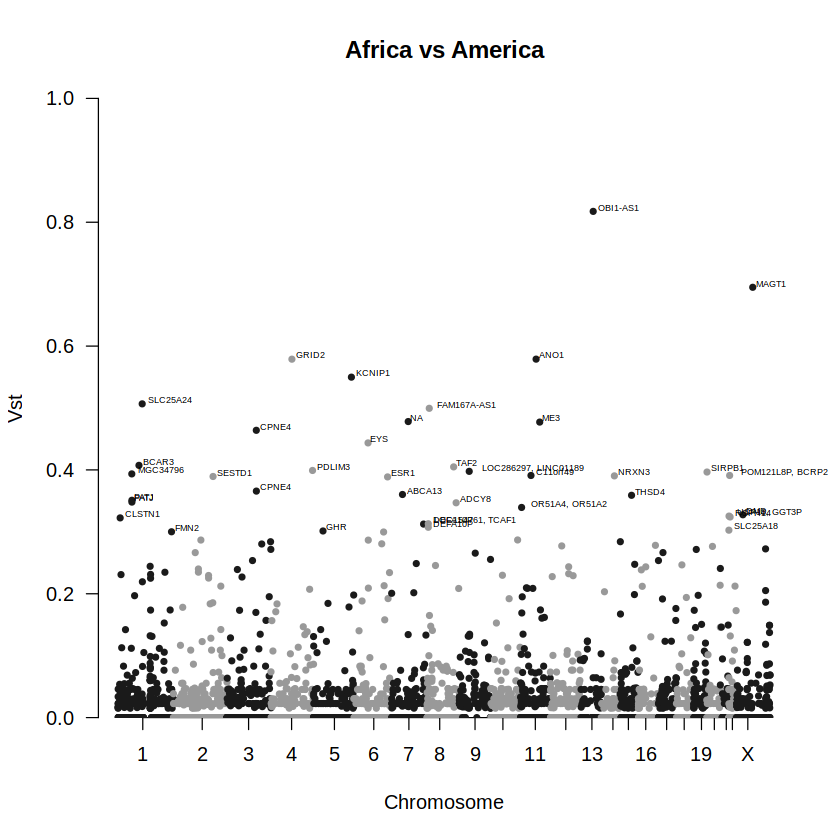

In [38]:
manhattan(df, logp = FALSE, annotatePval= 0.30,  annotateTop = FALSE, ylab="Vst", main='Africa vs America', chrlabs= c(1:22,"X"))

<h1> Manhattan plot for each group

In [21]:
SNP <- df_merge$genes
CHR <- as.integer(df_merge$chr)
BP <- df_merge$start
#P <- df_merge$WestEurasia.Oceania

coordinates <- data.frame(SNP,CHR,BP)
coordinates$CHR[is.na(coordinates$CHR)] <- "X"
coordinates


SNP,CHR,BP
<chr>,<chr>,<int>
MFSD14A,1,100517299
RBP7,1,10067509
RNF223,1,1009660
OLFM3,1,102395735
KIF1B,1,10272327
KIF1B,1,10282248
C1orf159,1,1051484
PEX14,1,10630864
NTNG1,1,107891259


In [22]:
names(df_merge[5:25])

[1] "WestEurasia.SouthAsia"          "WestEurasia.Africa"            
 [3] "WestEurasia.CentralAsiaSiberia" "WestEurasia.Oceania"           
 [5] "WestEurasia.America"            "WestEurasia.EastAsia"          
 [7] "SouthAsia.Africa"               "SouthAsia.CentralAsiaSiberia"  
 [9] "SouthAsia.Oceania"              "SouthAsia.America"             
[11] "SouthAsia.EastAsia"             "Africa.CentralAsiaSiberia"     
[13] "Africa.Oceania"                 "Africa.America"                
[15] "Africa.EastAsia"                "CentralAsiaSiberia.Oceania"    
[17] "CentralAsiaSiberia.America"     "CentralAsiaSiberia.EastAsia"   
[19] "Oceania.America"                "Oceania.EastAsia"              
[21] "America.EastAsia"

In [23]:
## SAVING PLOTS 
mylist <- list()
for(i in  seq_along(df_merge[,5:ncol(df_merge)])){

  mylist[[i]] <- df_merge[,c(4,1,2,(i+4))]
    names(mylist[[i]])[1] <- 'SNP'
    names(mylist[[i]])[2] <- 'CHR'
    names(mylist[[i]])[3] <- 'BP'
    names(mylist[[i]])[4] <- 'P'
    mylist[[i]][4][is.na(mylist[[i]][4])] <- 0 

  
  png(file=paste0("manhattan_plots/",names(df_merge[5:25])[i],".png"))  #+names(df_merge[5:25])[i]+
  manhattan(mylist[[i]], logp = FALSE,  annotatePval= 0.20, annotateTop = FALSE, main=names(df_merge[5:25])[i],  ylab="Vst", chrlabs= c(1:22,"X"))
  dev.off() 

}

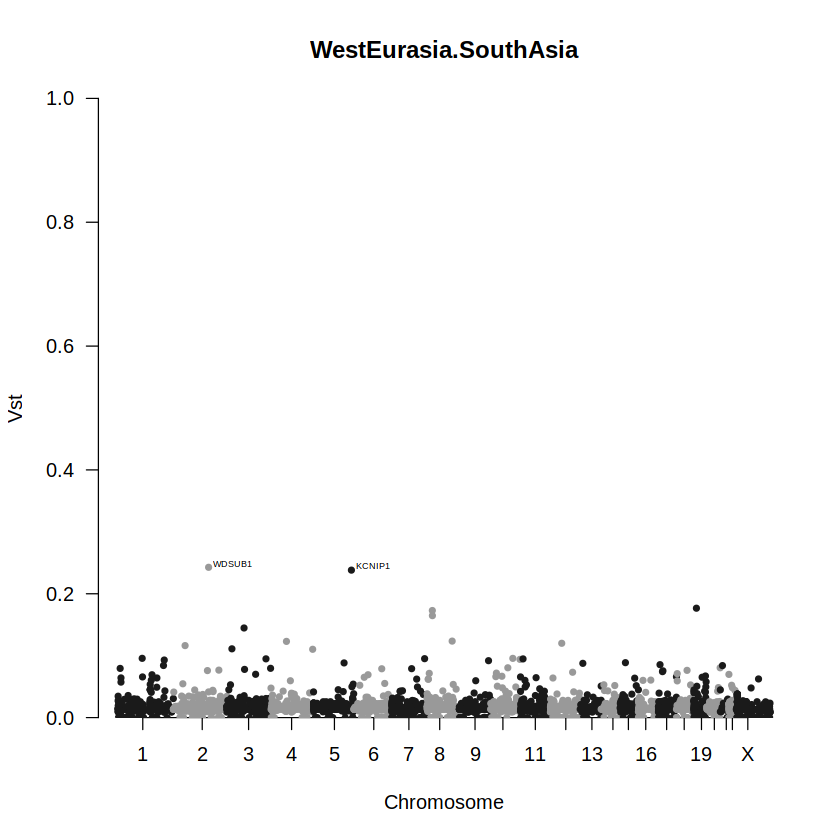

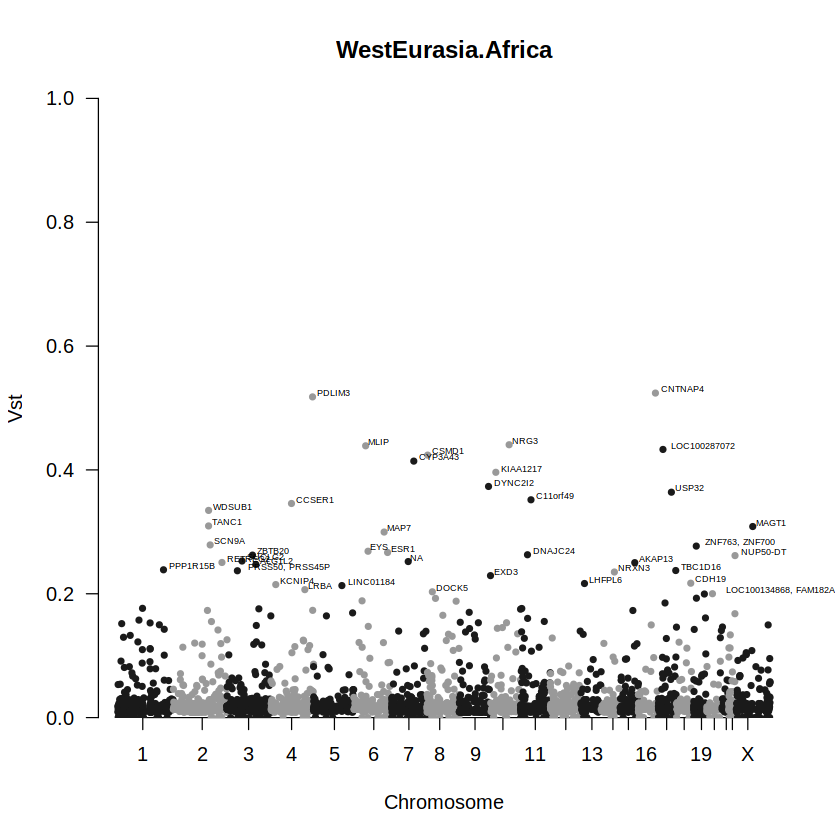

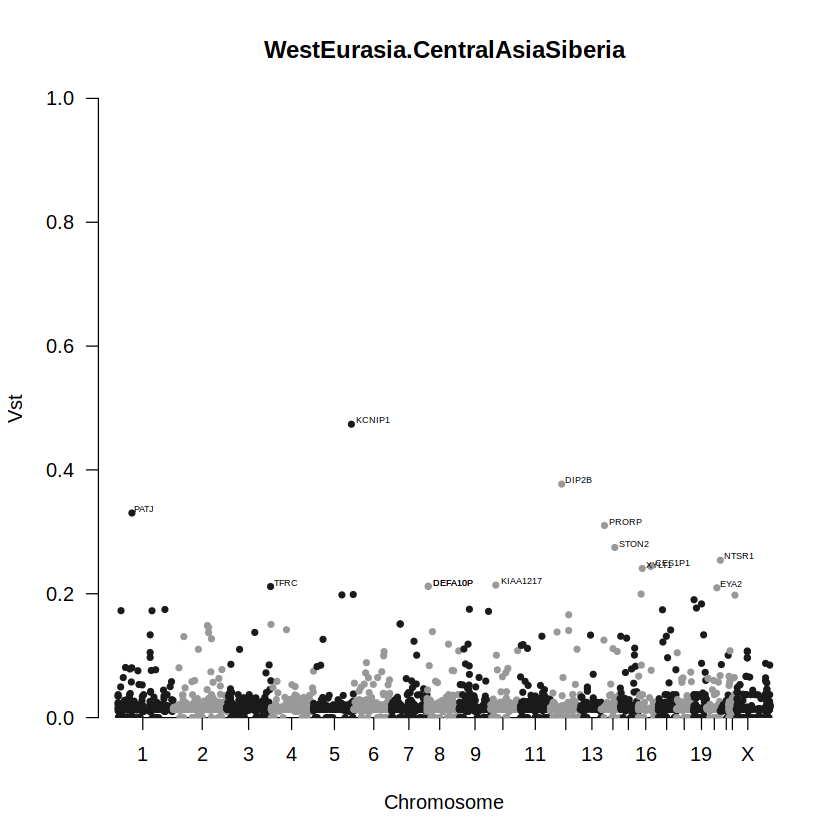

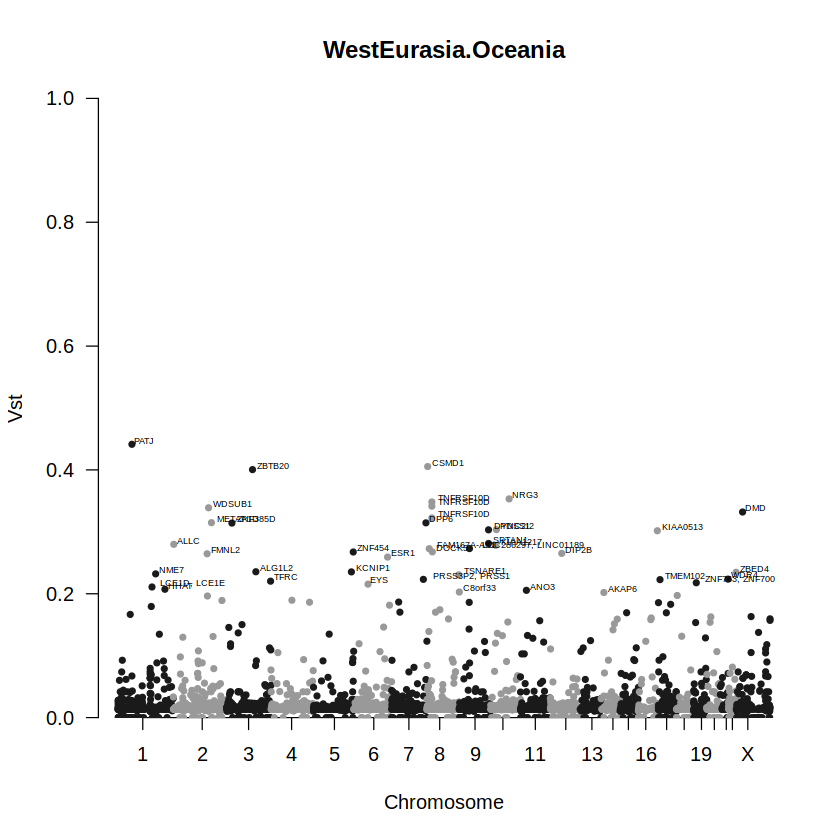

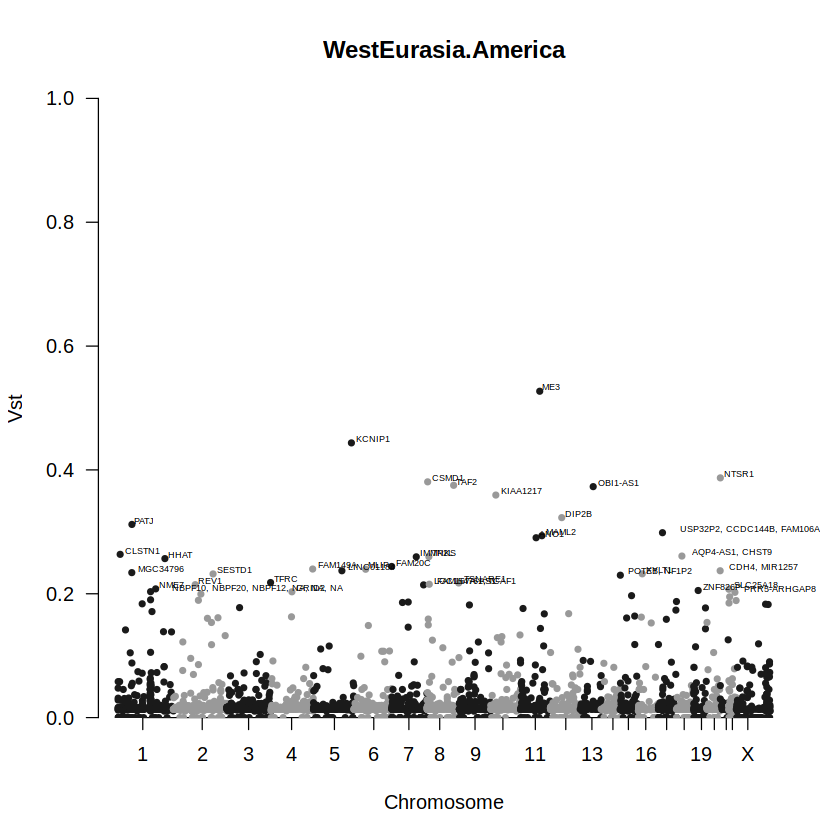

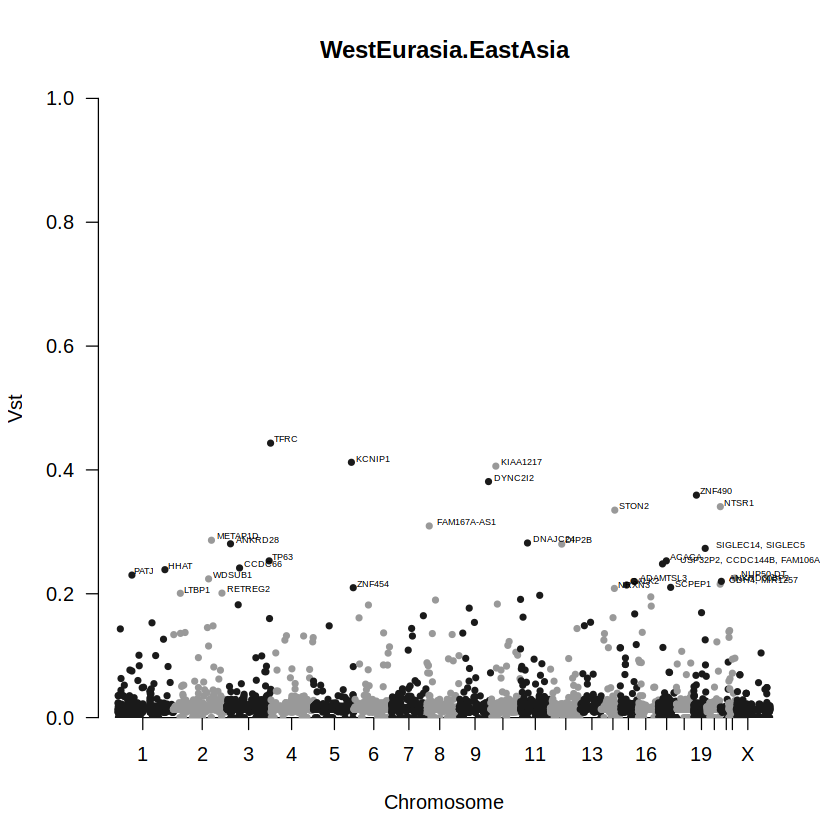

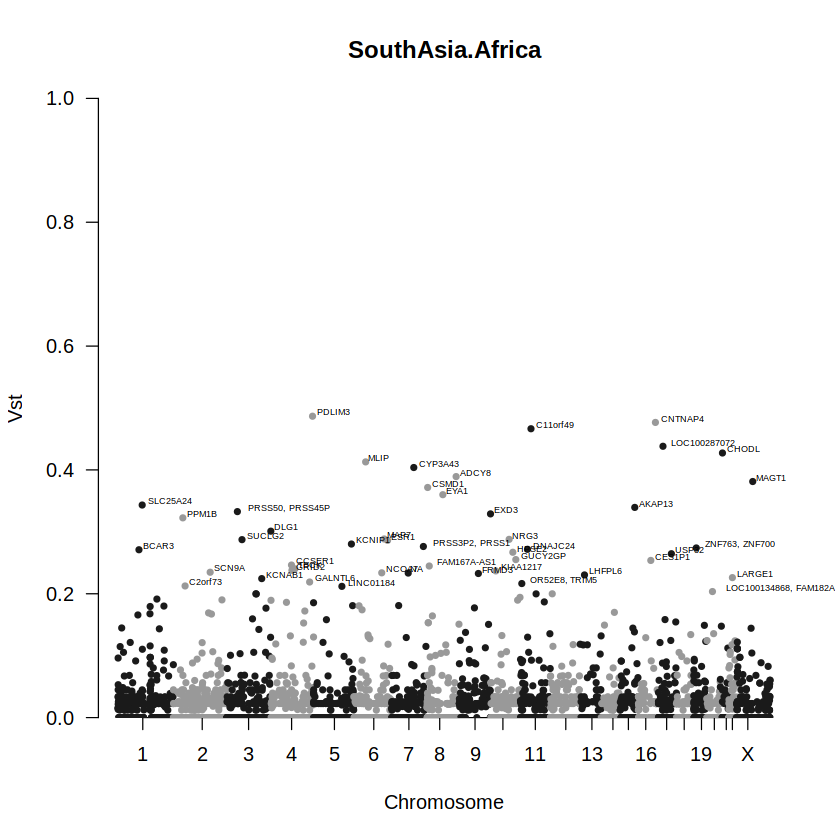

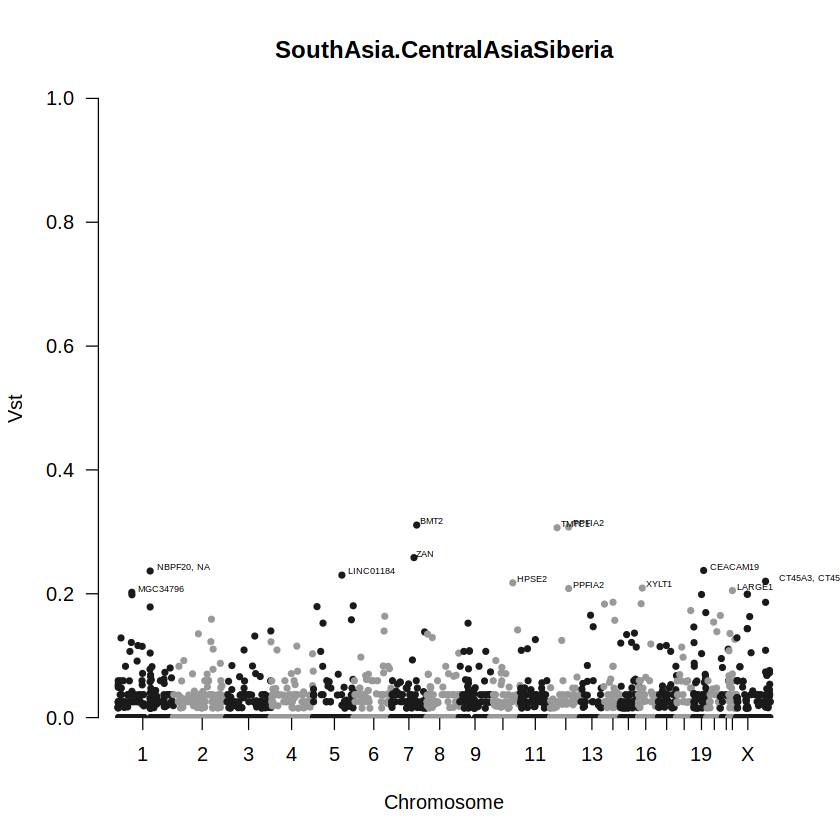

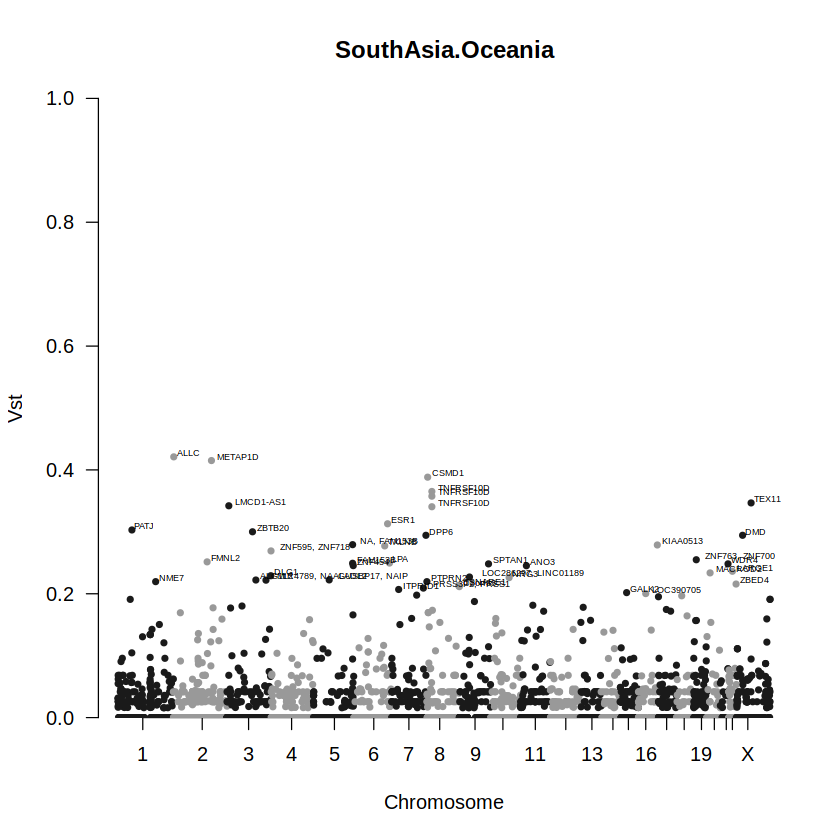

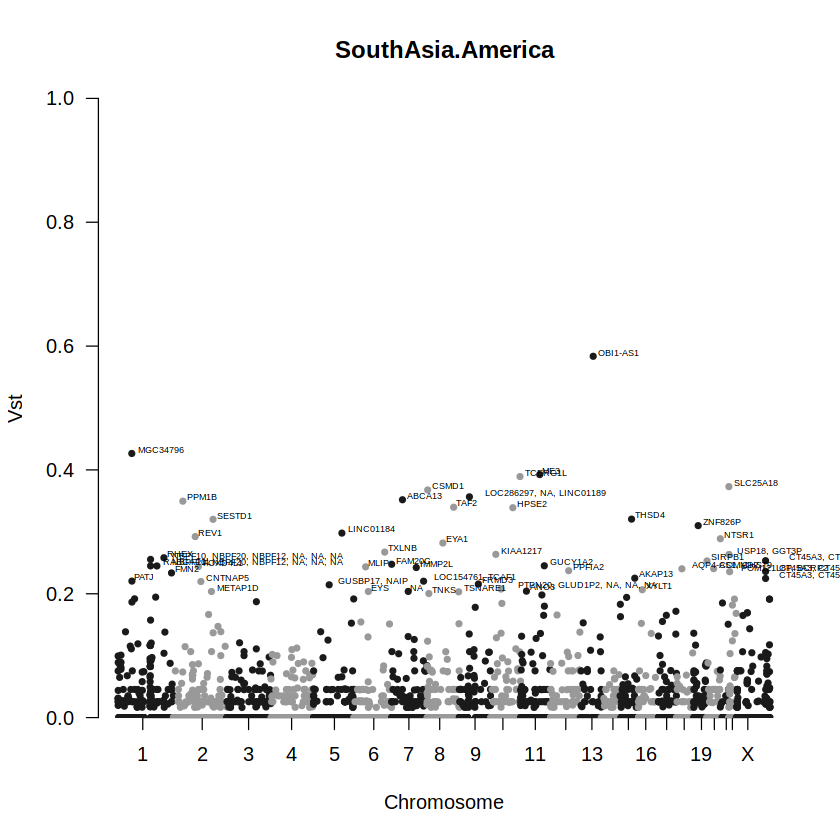

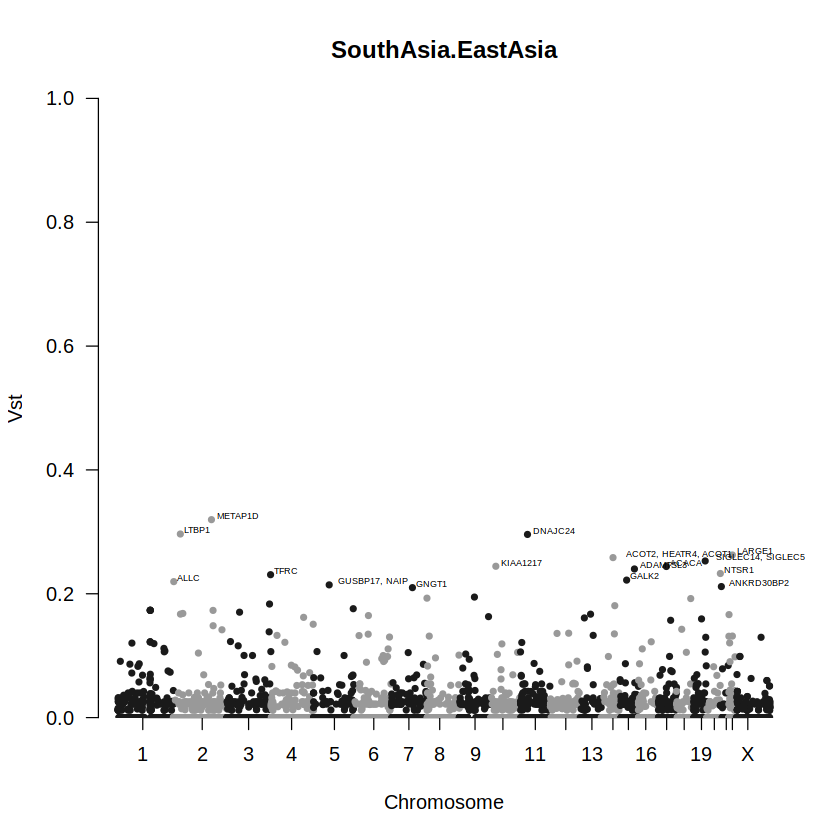

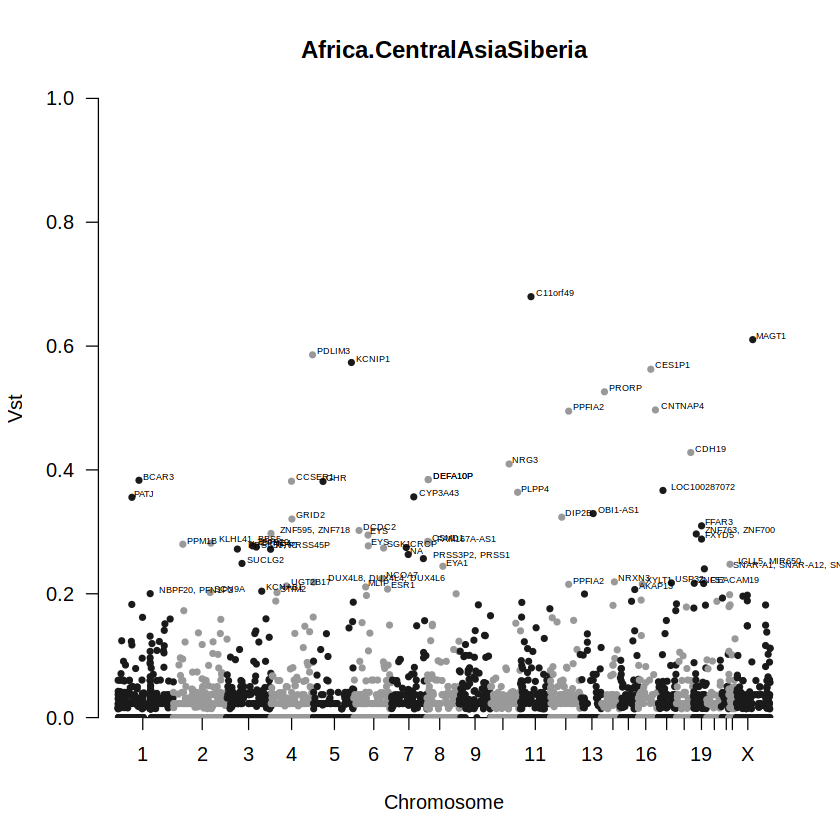

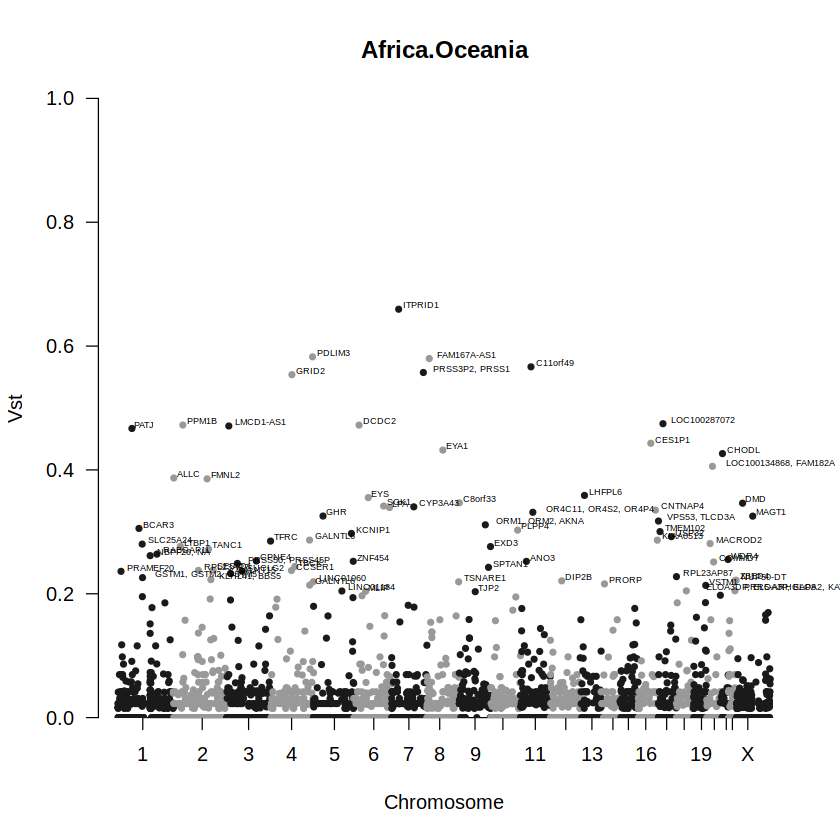

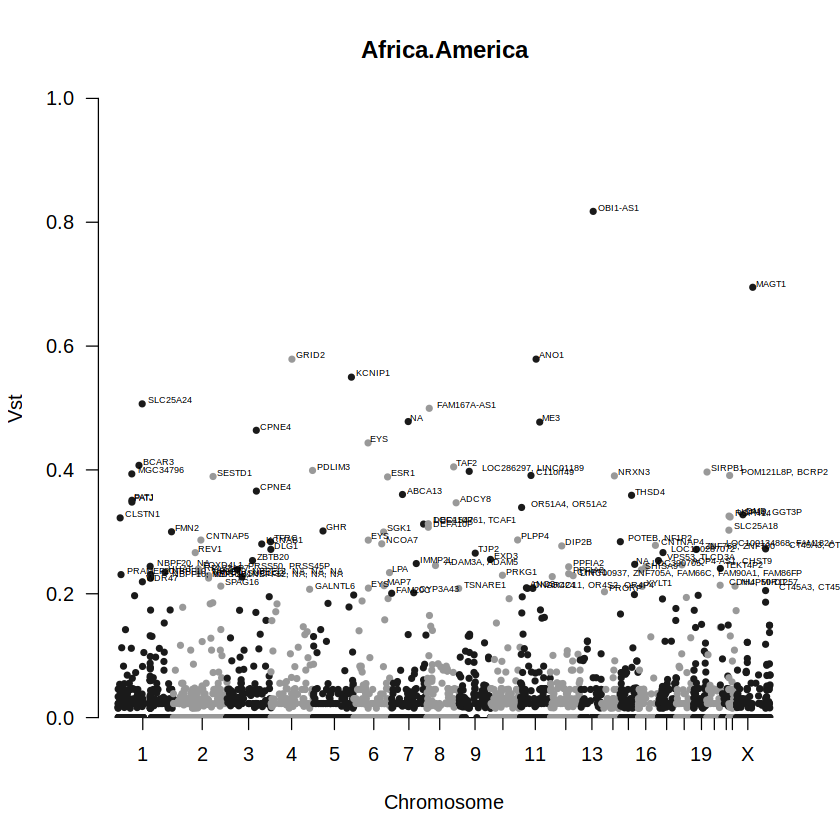

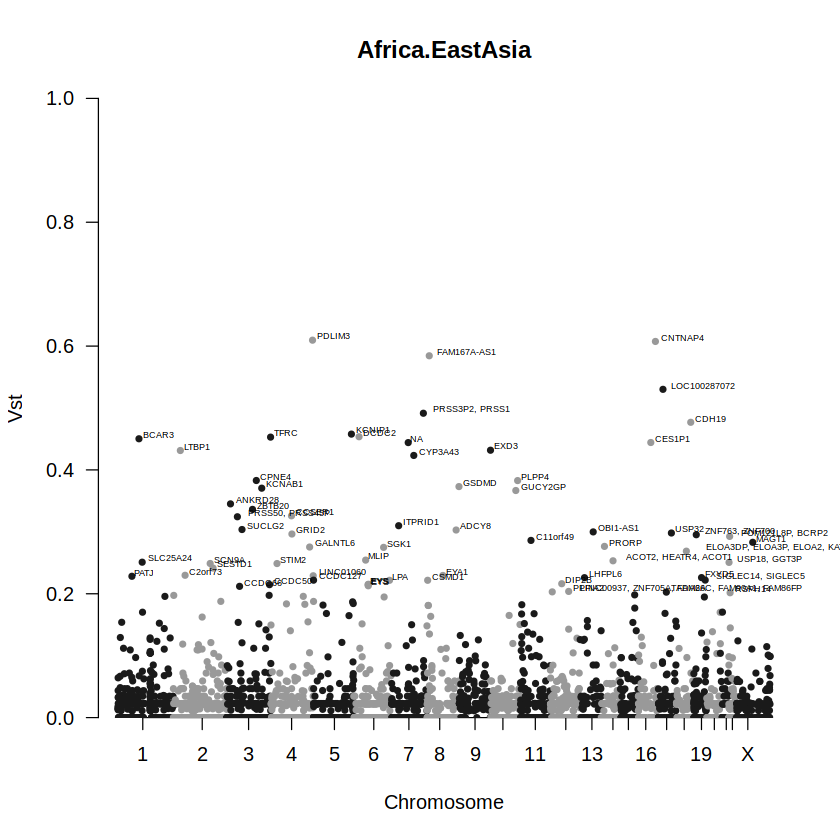

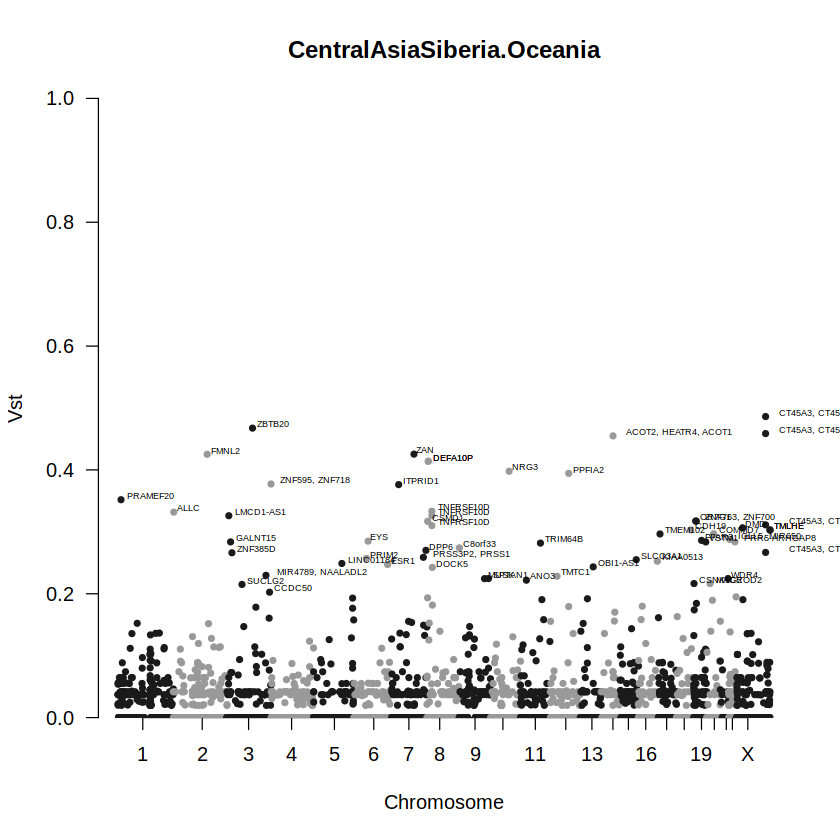

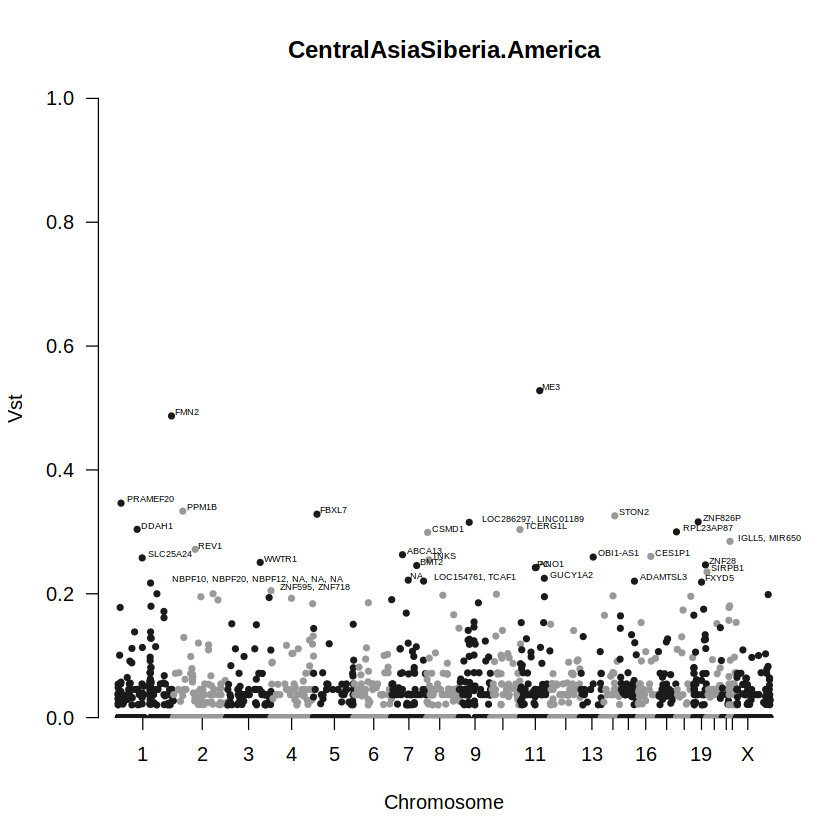

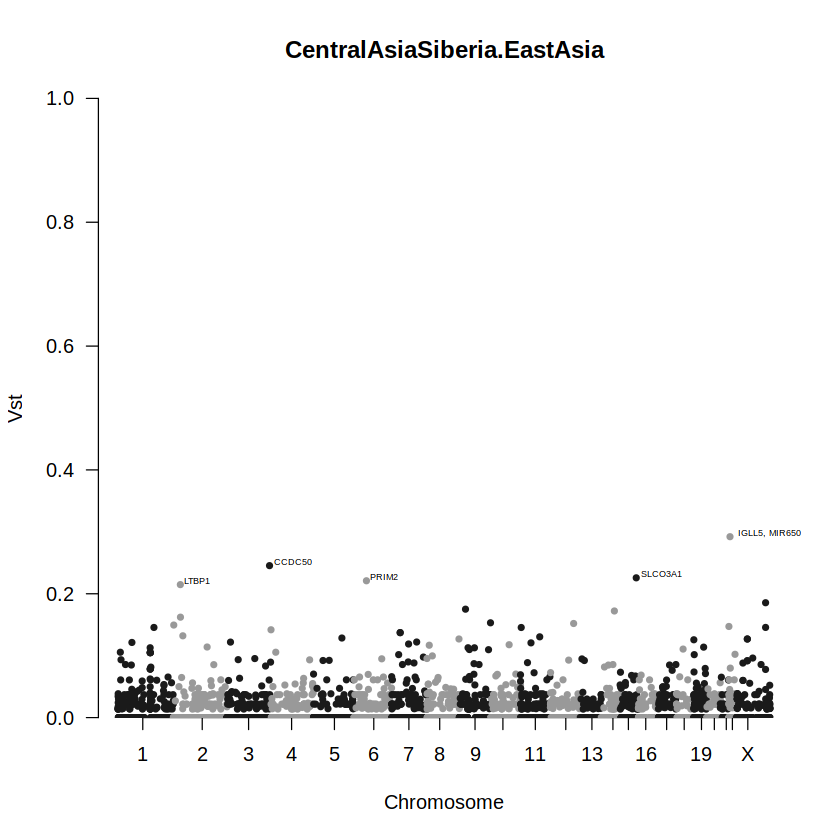

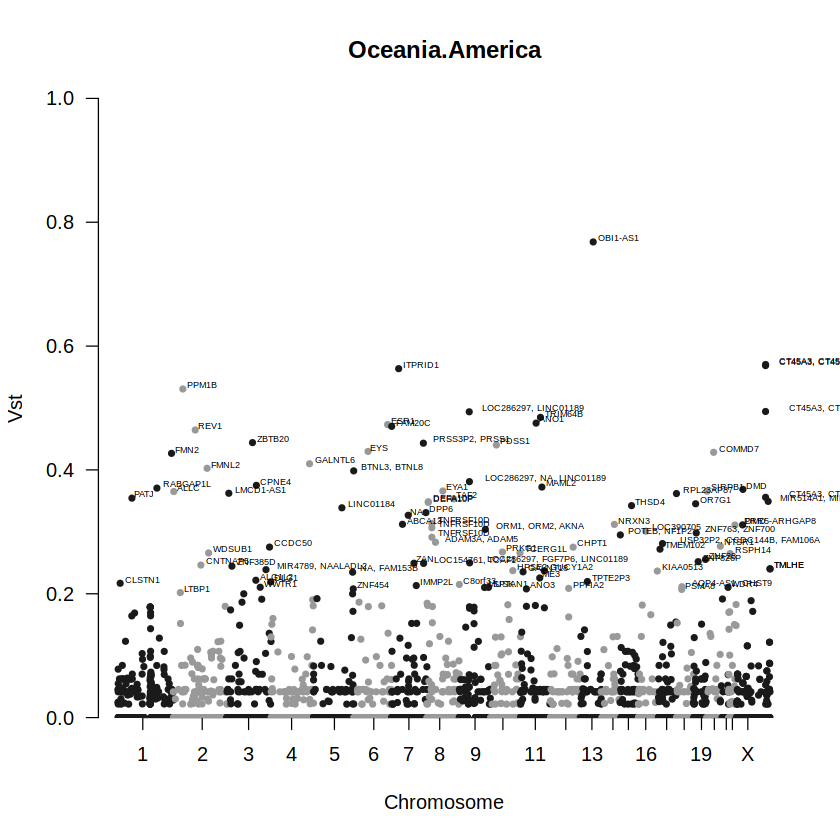

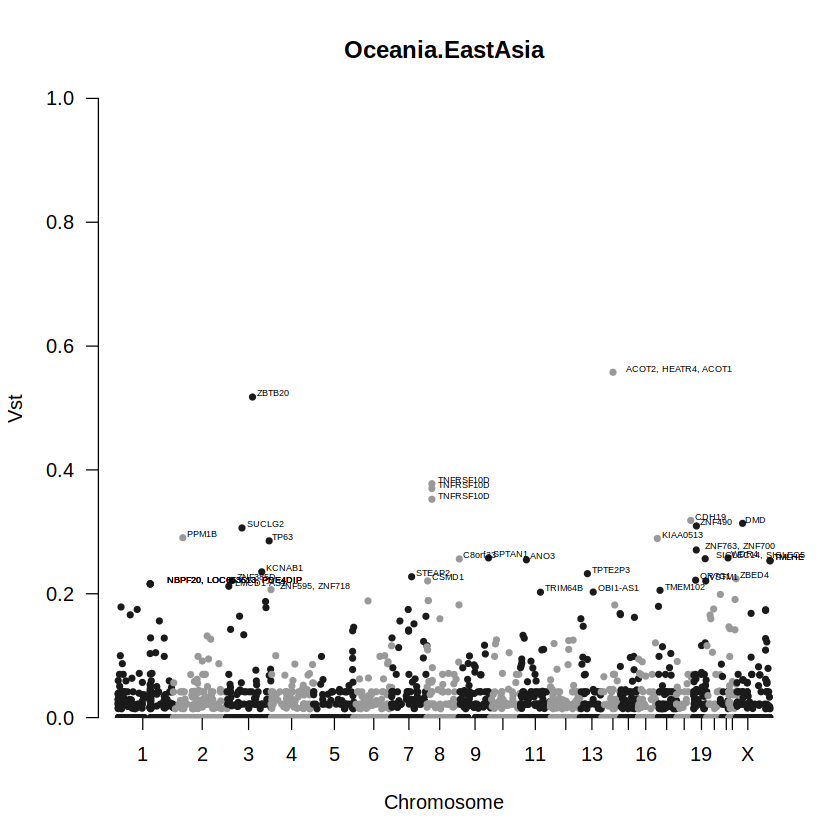

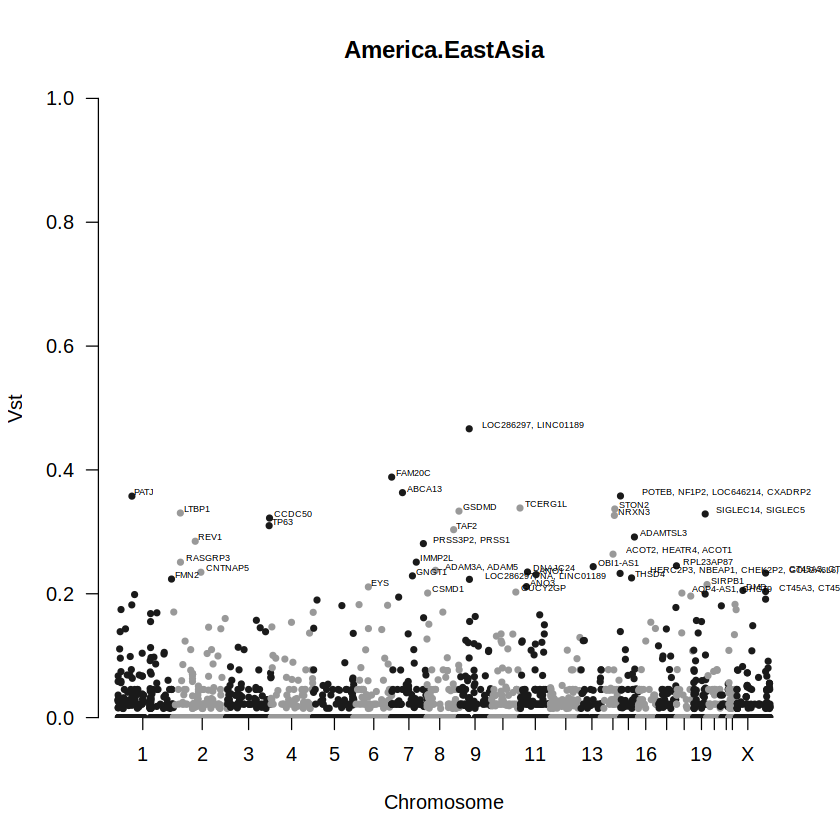

In [24]:
mylist <- list()
for(i in  seq_along(df_merge[,5:ncol(df_merge)])){

  mylist[[i]] <- df_merge[,c(4,1,2,(i+4))]
    names(mylist[[i]])[1] <- 'SNP'
    names(mylist[[i]])[2] <- 'CHR'
    names(mylist[[i]])[3] <- 'BP'
    names(mylist[[i]])[4] <- 'P'
    mylist[[i]][4][is.na(mylist[[i]][4])] <- 0 

  
  manhattan(mylist[[i]], logp = FALSE,  annotatePval= 0.20, annotateTop = FALSE, main=names(df_merge[5:25])[i],  ylab="Vst", chrlabs= c(1:22,"X")) 

}